In [12]:
from pathlib import Path

import numpy as np
import pandas as pd
import dask.dataframe as dd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# %matplotlib inline

In [13]:
chunk_size = 10**6

# read container_meta table
container_meta_data_path = 'data/container_meta.csv'
cm_headers=['container_id','machine_id','time_stamp','app_du', 'status', 'cpu_request', 'cpu_limit', 'mem_size']
container_meta_dataframe = pd.read_csv(container_meta_data_path, header=None, index_col=False, names=cm_headers,delimiter=',')
container_time_df = container_meta_dataframe[['container_id','time_stamp','status','app_du','cpu_request','mem_size']]
cm_stopped_dataframe = container_time_df[container_time_df['status'] == 'stopped']
cm_started_dataframe = container_time_df[container_time_df['status'] == 'started']

container_meta_dataframe_merged = pd.merge(cm_started_dataframe,cm_stopped_dataframe, suffixes=['_start','_end'] ,on='container_id', how='inner')


In [14]:
df = container_meta_dataframe.sort_values(by='time_stamp',ascending=True)
df = df[df["time_stamp"]>0]
df.head(100)

,container_id,machine_id,time_stamp,app_du,status,cpu_request,cpu_limit,mem_size
76833,c_14808,m_2687,66,app_2562,started,800,800,3.13
6955,c_1353,m_1231,130,app_2562,started,800,800,3.13
307936,c_59462,m_1461,136,app_2562,started,800,800,3.13
175308,c_33786,m_298,148,app_2562,started,800,800,3.13
18762,c_3629,m_1789,196,app_2562,started,800,800,3.13
...,...,...,...,...,...,...,...,...
213211,c_41114,m_298,438,app_3632,started,400,400,1.56
270211,c_52127,m_298,438,app_3746,started,400,400,1.56
43877,c_8482,m_298,438,app_2737,started,400,400,1.56
49322,c_9540,m_298,438,app_2903,started,400,400,1.56


In [15]:
# container_meta_dataframe[(container_meta_dataframe["status"] == "started") & (container_meta_dataframe["time_stamp"] > 0)]

In [16]:
container_meta_dataframe.describe()

,time_stamp,cpu_request,cpu_limit,mem_size
count,370540.000000,370540.000000,370540.000000,370540.000000
mean,183731.625476,506.633832,522.922330,2.057853
std,164374.170185,256.780818,340.458346,1.372060
min,0.000000,100.000000,100.000000,0.000000
25%,21791.000000,400.000000,400.000000,1.560000
50%,162818.000000,400.000000,400.000000,1.560000
75%,283635.000000,400.000000,480.000000,1.560000
max,694879.000000,3200.000000,19200.000000,25.000000


In [17]:
container_meta_dataframe['status'].value_counts()

status
started      368100
stopped        2265
allocated       170
unknow            5
Name: count, dtype: int64

In [18]:
container_meta_dataframe[container_meta_dataframe['time_stamp']==0]

,container_id,machine_id,time_stamp,app_du,status,cpu_request,cpu_limit,mem_size
0,c_1,m_2556,0,app_5052,started,400,400,1.56
3,c_2,m_962,0,app_8125,started,800,800,3.13
8,c_3,m_644,0,app_66,started,400,400,1.56
13,c_4,m_1423,0,app_3222,started,400,400,1.56
20,c_5,m_334,0,app_5955,started,400,400,1.56
...,...,...,...,...,...,...,...,...
370513,c_71472,m_2968,0,app_1479,started,400,400,1.56
370518,c_71473,m_2097,0,app_7048,started,400,400,1.56
370524,c_71474,m_771,0,app_6180,started,400,480,1.56
370528,c_71475,m_3580,0,app_1844,started,800,800,3.13


In [19]:
container_meta_dataframe_merged['lifetime'] = np.maximum((
    container_meta_dataframe_merged['time_stamp_end'] - 
    container_meta_dataframe_merged['time_stamp_start']), 300) / 3600

In [20]:
container_meta_dataframe_merged.head(100)

,container_id,time_stamp_start,status_start,app_du_start,cpu_request_start,mem_size_start,time_stamp_end,status_end,app_du_end,cpu_request_end,mem_size_end,lifetime
0,c_417,580453,started,app_3665,400,1.56,683099,stopped,app_3665,400,1.56,28.512778
1,c_417,580453,started,app_3665,400,1.56,693993,stopped,app_3665,400,1.56,31.538889
2,c_417,588822,started,app_3665,400,1.56,683099,stopped,app_3665,400,1.56,26.188056
3,c_417,588822,started,app_3665,400,1.56,693993,stopped,app_3665,400,1.56,29.214167
4,c_417,594525,started,app_3665,400,1.56,683099,stopped,app_3665,400,1.56,24.603889
...,...,...,...,...,...,...,...,...,...,...,...,...
95,c_7686,259432,started,app_7804,400,1.56,12328,stopped,app_7804,400,1.56,0.083333
96,c_7686,419082,started,app_7804,400,1.56,0,stopped,app_7804,400,1.56,0.083333
97,c_7686,419082,started,app_7804,400,1.56,12328,stopped,app_7804,400,1.56,0.083333
98,c_7686,678042,started,app_7804,400,1.56,0,stopped,app_7804,400,1.56,0.083333


In [21]:
container_meta_dataframe_merged.describe()

,time_stamp_start,cpu_request_start,mem_size_start,time_stamp_end,cpu_request_end,mem_size_end,lifetime
count,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000
mean,327378.344114,627.425614,2.921552,379321.794308,627.425614,2.921552,35.099435
std,207736.289537,315.486664,2.534736,254657.709319,315.486664,2.534736,45.629480
min,0.000000,100.000000,0.380000,0.000000,100.000000,0.380000,0.083333
25%,209205.000000,400.000000,1.560000,165348.000000,400.000000,1.560000,0.083333
50%,285084.000000,400.000000,1.560000,342828.000000,400.000000,1.560000,24.603889
75%,578608.000000,800.000000,3.130000,678048.000000,800.000000,3.130000,47.252222
max,684864.000000,1600.000000,11.720000,694164.000000,1600.000000,11.720000,192.227222


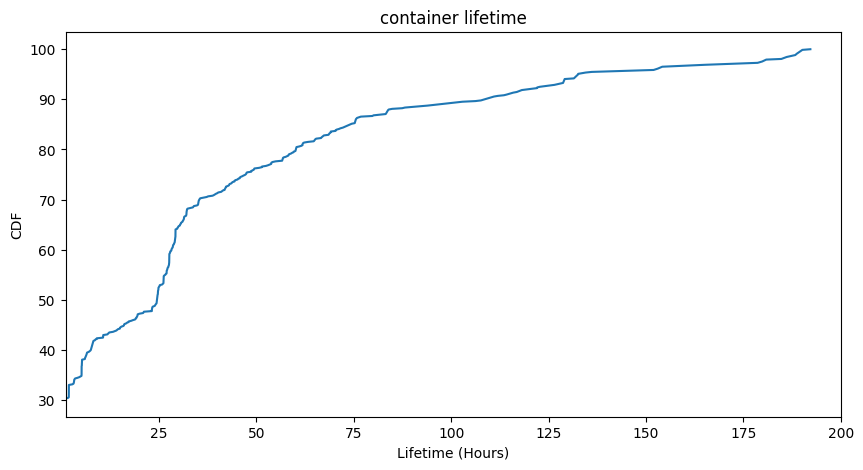

In [23]:
TraceLegend = "Alibaba Trace 2018"
def LifetimePlot(df):
    df=df[df["lifetime"] > 0]
    counts_lifetime = pd.DataFrame(df.groupby(['lifetime']).size().rename('Freq')).reset_index()
    counts_lifetime['cum'] = counts_lifetime['Freq'].cumsum() / counts_lifetime['Freq'].sum() * 100
    plt.figure(figsize=(10, 5))
    plt.title("container lifetime")
    ax = sns.lineplot(x="lifetime", y="cum",data=counts_lifetime)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Lifetime (Hours)')
    ax.set_ylabel('CDF')
    # zoom in
    ax.set_xlim([1,200])
    plt.show()

LifetimePlot(container_meta_dataframe_merged)